# Fandango Ratings: Redux
In October 2015, a data journalist named Walt Hickey found that Fandango's rating system was biased, with film ratings being displayed as higher than their actual value.

Fandango claimed a bug and promised to fix the issue. Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

In [79]:
# Import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We have two datasets to work on: the original dataset produced by Hickey for his article, and a second dataset compiled a couple of years later (not by Hickey) to compare Fandango and a few other film review websites. Let's load them and take a look.

In [80]:
# Load data
before = pd.read_csv("fandango_score_comparison.csv")
after = pd.read_csv("movie_ratings_16_17.csv")

In [81]:
after.shape

(214, 15)

In [82]:
before.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [83]:
before.dtypes

FILM                           object
RottenTomatoes                  int64
RottenTomatoes_User             int64
Metacritic                      int64
Metacritic_User               float64
IMDB                          float64
Fandango_Stars                float64
Fandango_Ratingvalue          float64
RT_norm                       float64
RT_user_norm                  float64
Metacritic_norm               float64
Metacritic_user_nom           float64
IMDB_norm                     float64
RT_norm_round                 float64
RT_user_norm_round            float64
Metacritic_norm_round         float64
Metacritic_user_norm_round    float64
IMDB_norm_round               float64
Metacritic_user_vote_count      int64
IMDB_user_vote_count            int64
Fandango_votes                  int64
Fandango_Difference           float64
dtype: object

In [84]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [85]:
after.dtypes

movie            object
year              int64
metascore         int64
imdb            float64
tmeter            int64
audience          int64
fandango        float64
n_metascore     float64
n_imdb          float64
n_tmeter        float64
n_audience      float64
nr_metascore    float64
nr_imdb         float64
nr_tmeter       float64
nr_audience     float64
dtype: object

In [86]:
F_before = before[["FILM","Fandango_Stars","Fandango_Ratingvalue","Fandango_votes","Fandango_Difference"]].copy()
F_after = after[["movie","year","fandango"]].copy()

###### The two datasets aren't straightforward to compare:
- The original one had a parameter for the real value and a parameter for the displayed value, while the second has just one single value (since Fandango has removed the actual values from the HTML of the movie pages). This is due to the different goal of the two datasets: the first one focused on the inner workings of the Fandango review system, the second on a comparison between Fandango and other reviewer websites.
- Furthermore, the timeframe is different. This is what we wanted, since our goal is to determine whether the rating system has changed in the intervening time or not, but at the same time it also means that we cannot be sure that the two populations are actually comparable (2015 may have had genuinely better films than 2016 and viceversa).
- Finally, the first set contains popular movies as defined by having more than 30 user reviews. The second set contains "214 of the most popular movies (with a significant number of votes)", but doesn't specify how many votes are a "significant number".

Of these 3 issues, only the third one can be addressed in a somewhat straightforward manner. We should check that at least a large majority of movies from the second set had more than 30 user reviews (possibly manually). This will repurpose our analysis to simply checking whether the distribution of Fandango votes has changed substantially between the two years. Our new goal will be then to decide whether any difference is likely to be due to a change in the review system or just due to a genuine difference in average movie quality between the two years. Rating values from the other review websites (which we know haven't changed their rating system) should help us on this point. 

In [87]:
# Let's sample randomly ~10% of the movies (20) from the second dataset and check manully check how many user reviews are there on the Fandango website.
sample = F_after.sample(20, random_state=1)
sample

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Here are the results of our manual search on the Fandango website:

| Movie title | User ratings |
|-------------|--------------|
| Mechanic: Resurrection | 2248 |
| Warcraft | 7278 |
| Max Steel | 493 |
| Me Before You	 | 5269 |
| Fantastic Beasts and Where to Find Them | 13453 |
| Cell | 18 |
| Genius | 127 |
| Sully | 11884 |
| A Hologram for the King | 500 |
| Captain America: Civil War | 35121 |
| Mr. Church | 182 |
| Crouching Tiger, Hidden Dragon: Sword of Destiny | 45 |
| Kung Fu Panda 3 | 5872 |
| Hidden Figures | 11779 |
| The Autopsy of Jane Doe | 41 |
| Misconduct | 22 |
| La La Land | 9300 |
| Live by Night | 922 |
| Suicide Squad | 39412 |
| Criminal | 1997 |

90% of our random sample has more than 30 user ratings so we can trust the two populations to be largely compatible as far as their own "popularity" score goes.

In [88]:
# Let's focus on just 2015 movies and 2016 movies.
movies2015 = F_before[F_before["FILM"].str.contains("2015")]
movies2016 = F_after[F_after["year"] == 2016]

In [89]:
movies2015.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [90]:
movies2016.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Text(0,0.5,'Density')

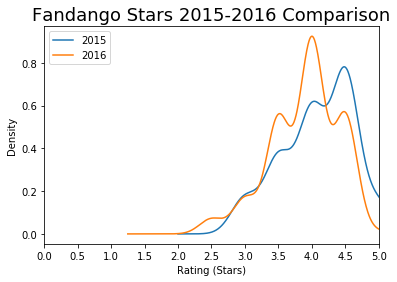

In [91]:
fig, ax = plt.subplots()
movies2015["Fandango_Stars"].plot.kde(label="2015",legend=True,ax=ax)
movies2016["fandango"].plot.kde(label="2016",legend=True,ax=ax)
ax.set_title("Fandango Stars 2015-2016 Comparison",fontsize=18)
ax.set_xlim([0,5])
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlabel("Rating (Stars)")
ax.set_ylabel("Density")

Fandango movie ratings show clear differences in 2016 compared to 2015:
- Both distributions have negative skew, but the 2016 distribution is far more symmetric.
- The mode was 4.5 in 2015, and is 4.0 on 2016.
- The 2016 distribution has noticeably less 4.5-5.0 values and noticeably more 3.5-4.0 values.

Overall, movies were rated lower on average in 2016 than they were in 2015.
#### Data indicates that there was indeed a change between 2015 and 2016.

Let's check the actual percentages.

In [92]:
print("2015\n---------")
movies2015_freqs = movies2015["Fandango_Stars"].value_counts(normalize = True).sort_index()*100
movies2015_freqs

2015
---------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [93]:
print("2016\n---------")
movies2016_freqs = movies2016["fandango"].value_counts(normalize = True).sort_index()*100
movies2016_freqs

2016
---------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

The percentages confirm what we've seen with the KDE plots. 
- No movies had 2.5 stars in 2015, while in 2016 a little more than 3% did.
- 3.5 and 4.0 stars grew from 17.8% and 28.7% to 24.1% and 40.3%, while 4.5 and 5.0 stars declined from 38% and 7% to 24.6% and 0.5%.

Let's now look at some summary statistics: mean, median and mode.

In [94]:
movies2015_mean = movies2015["Fandango_Stars"].mean()
movies2015_median = movies2015["Fandango_Stars"].median()
movies2015_mode = movies2015["Fandango_Stars"].mode()[0]
movies2016_mean = movies2016["fandango"].mean()
movies2016_median = movies2016["fandango"].median()
movies2016_mode = movies2016["fandango"].mode()[0]

In [95]:
stats = pd.DataFrame()
stats["2015"] = [movies2015_mean,movies2015_median,movies2015_mode]
stats["2016"] = [movies2016_mean,movies2016_median,movies2016_mode]
stats.index = ["Mean","Median","Mode"]
stats

,2015,2016
Mean,4.085271,3.887435
Median,4.000000,4.000000
Mode,4.500000,4.000000


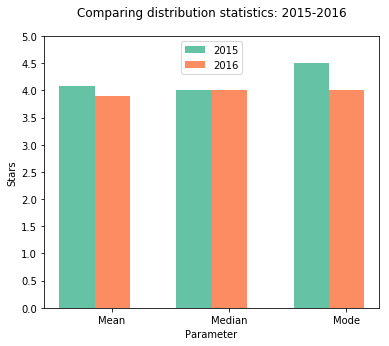

In [96]:
width = .3
fig, ax = plt.subplots(figsize=(6,5))
f1 = ax.bar(np.arange(3),stats["2015"],width,color=plt.cm.Set2(0))
f2 = ax.bar(np.arange(3)+width,stats["2016"],width,color=plt.cm.Set2(.20))
#stats["2015"].plot.bar(color="b",label="2015",legend=True)
#stats["2016"].plot.bar(color="r",label="2016",legend=True)
ax.set_title("Comparing distribution statistics: 2015-2016", y = 1.05)
ax.set_xlabel("Parameter")
ax.set_ylabel("Stars")
ax.set_ylim([0.0,5.0])
ax.set_xticks([.3,1.3,2.3])
ax.set_yticks(np.arange(0,5.5,.5))
ax.set_xticklabels(stats.index)
ax.legend((f1[0], f2[0]), ('2015', '2016'), loc="upper center")
ax.autoscale_view()

The summary statistics convey that the median of the populations remained the same, with four stars being the half-population split both in 2015 and 2016. Mean and mode however decreased in 2016, indicating that what is happening here is more or less a change of the shape of the distributions, as we can also confirm visually thanks to the KDE plots above.

For final confirmation, let's test the significance of the changes in the mean with a two_tailed approximate permutation test.

In [97]:
abs_mean_diff = abs(stats.at["Mean","2016"]-stats.at["Mean","2015"])
print("Difference of means (absolute): ", abs_mean_diff)

Difference of means (absolute):  0.19783676285563567


In [102]:
# Now we sample randomly from both sets and create new distributions with new differences in mean and mode. 
all_scores = movies2015["Fandango_Stars"].append(movies2016["fandango"])
abs_mean_diffs = []
for i in range(1000):
    dist_a = []
    dist_b = []
    for i in all_scores:
        if np.random.rand() >= .5:
            dist_a.append(i)
        else:
            dist_b.append(i)
    iter_mean_diff = abs(np.mean(dist_b)-np.mean(dist_a))
    abs_mean_diffs.append(iter_mean_diff)

In [103]:
# How often are these differences greater than the ones we obtained with the real distributions?
frequency = 0
for i in abs_mean_diffs:
    if i >= abs_mean_diff:
        frequency += 1
p_value_mean = frequency/len(abs_mean_diffs)
frequency = 0
for i in abs_mode_diffs:
    if i >= abs_mode_diff:
        frequency += 1
p_value_mode = frequency/len(abs_mode_diffs)
print("P-value (mean, two-tailed): ", p_value_mean)

P-value (mean, two-tailed):  0.001


The p-value is well below the traditional 5% confidence threshold, meaning that it is highly unlikely that the change in distribution means between 2015 and 2016 was a random occurrence.

##### The only thing left now is to explore whether the change is really due to a change in the rating system, or is in fact due to genuine differences in movie quality between 2015 and 2016.

To do so, let's compare 2015-2016 ratings for IMDB, Rotten Tomatoes and Metacritic - none of the three should have changed their review systems within this timeframe.

## IMDB

In [104]:
# As we did before for Fandango, let's select the useful columns and filter by year
I_before = before[["FILM","IMDB_norm"]].copy()
I_after = after[["movie","year","n_imdb"]].copy()
imdb2015 = I_before[I_before["FILM"].str.contains("2015")]
imdb2016 = I_after[I_after["year"] == 2016]

In [105]:
imdb2015_mean = imdb2015["IMDB_norm"].mean()
imdb2015_median = imdb2015["IMDB_norm"].median()
imdb2015_mode = imdb2015["IMDB_norm"].mode()[0]
imdb2016_mean = imdb2016["n_imdb"].mean()
imdb2016_median = imdb2016["n_imdb"].median()
imdb2016_mode = imdb2016["n_imdb"].mode()[0]

In [108]:
stats = pd.DataFrame()
stats["2015"] = [imdb2015_mean,imdb2015_median,imdb2015_mode]
stats["2016"] = [imdb2016_mean,imdb2016_median,imdb2016_mode]
stats.index = ["Mean","Median","Mode"]
stats

,2015,2016
Mean,3.34186,3.229581
Median,3.35000,3.250000
Mode,3.30000,3.150000


Text(0,0.5,'Density')

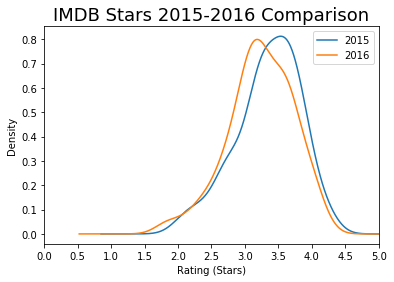

In [110]:
fig, ax = plt.subplots()
imdb2015["IMDB_norm"].plot.kde(label="2015",legend=True,ax=ax)
imdb2016["n_imdb"].plot.kde(label="2016",legend=True,ax=ax)
ax.set_title("IMDB Stars 2015-2016 Comparison",fontsize=18)
ax.set_xlim([0,5])
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlabel("Rating (Stars)")
ax.set_ylabel("Density")

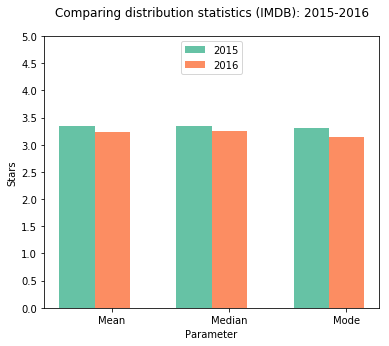

In [109]:
width = .3
fig, ax = plt.subplots(figsize=(6,5))
f1 = ax.bar(np.arange(3),stats["2015"],width,color=plt.cm.Set2(0))
f2 = ax.bar(np.arange(3)+width,stats["2016"],width,color=plt.cm.Set2(.20))
#stats["2015"].plot.bar(color="b",label="2015",legend=True)
#stats["2016"].plot.bar(color="r",label="2016",legend=True)
ax.set_title("Comparing distribution statistics (IMDB): 2015-2016", y = 1.05)
ax.set_xlabel("Parameter")
ax.set_ylabel("Stars")
ax.set_ylim([0.0,5.0])
ax.set_xticks([.3,1.3,2.3])
ax.set_yticks(np.arange(0,5.5,.5))
ax.set_xticklabels(stats.index)
ax.legend((f1[0], f2[0]), ('2015', '2016'), loc="upper center")
ax.autoscale_view()

The distributions aren't as markedly different (and are more nuanced since the IMDB scores are much more granular), but for IMDB too there was a decrease in the mean of the distributions between 2015 and 2016. Once again, let's test the significance of this difference using the two-tailed approximate permutation test.

In [111]:
abs_mean_diff = abs(stats.at["Mean","2016"]-stats.at["Mean","2015"])
print("Difference of means (absolute): ", abs_mean_diff)

Difference of means (absolute):  0.11227931328382068


In [116]:
# Now we sample randomly from both sets and create new distributions with new differences in mean and mode. 
all_scores = imdb2015["IMDB_norm"].append(imdb2016["n_imdb"])
abs_mean_diffs = []
for i in range(1000):
    dist_a = []
    dist_b = []
    for i in all_scores:
        if np.random.rand() >= .5:
            dist_a.append(i)
        else:
            dist_b.append(i)
    iter_mean_diff = abs(np.mean(dist_b)-np.mean(dist_a))
    abs_mean_diffs.append(iter_mean_diff)

In [117]:
# How often are these differences greater than the ones we obtained with the real distributions?
frequency = 0
for i in abs_mean_diffs:
    if i >= abs_mean_diff:
        frequency += 1
p_value_mean = frequency/len(abs_mean_diffs)
frequency = 0
for i in abs_mode_diffs:
    if i >= abs_mode_diff:
        frequency += 1
p_value_mode = frequency/len(abs_mode_diffs)
print("P-value (mean, two-tailed): ", p_value_mean)

P-value (mean, two-tailed):  0.039


The p-value for IMDB is larger, but still below the 5% confidence threshold. It is not, however, below the 1% threshold as the Fandango one was.

## Metacritic

In [118]:
# Let's select the useful columns and filter by year
M_before = before[["FILM","Metacritic_norm"]].copy()
M_after = after[["movie","year","n_metascore"]].copy()
metacritic2015 = M_before[M_before["FILM"].str.contains("2015")]
metacritic2016 = M_after[M_after["year"] == 2016]

In [119]:
metacritic2015_mean = metacritic2015["Metacritic_norm"].mean()
metacritic2015_median = metacritic2015["Metacritic_norm"].median()
metacritic2015_mode = metacritic2015["Metacritic_norm"].mode()[0]
metacritic2016_mean = metacritic2016["n_metascore"].mean()
metacritic2016_median = metacritic2016["n_metascore"].median()
metacritic2016_mode = metacritic2016["n_metascore"].mode()[0]

In [120]:
stats = pd.DataFrame()
stats["2015"] = [metacritic2015_mean,metacritic2015_median,metacritic2015_mode]
stats["2016"] = [metacritic2016_mean,metacritic2016_median,metacritic2016_mode]
stats.index = ["Mean","Median","Mode"]
stats

,2015,2016
Mean,2.84031,2.682461
Median,2.80000,2.700000
Mode,3.35000,2.900000


Text(0,0.5,'Density')

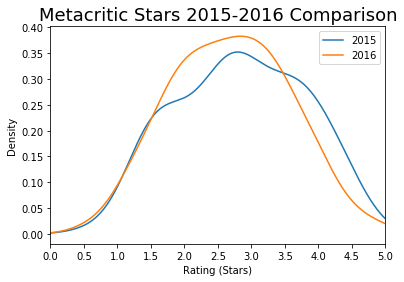

In [121]:
fig, ax = plt.subplots()
metacritic2015["Metacritic_norm"].plot.kde(label="2015",legend=True,ax=ax)
metacritic2016["n_metascore"].plot.kde(label="2016",legend=True,ax=ax)
ax.set_title("Metacritic Stars 2015-2016 Comparison",fontsize=18)
ax.set_xlim([0,5])
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlabel("Rating (Stars)")
ax.set_ylabel("Density")

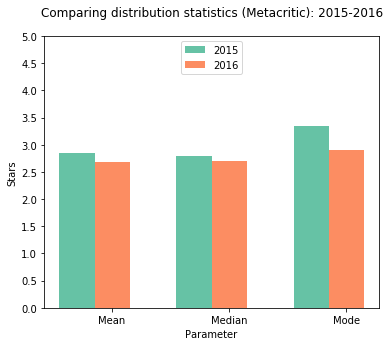

In [122]:
width = .3
fig, ax = plt.subplots(figsize=(6,5))
f1 = ax.bar(np.arange(3),stats["2015"],width,color=plt.cm.Set2(0))
f2 = ax.bar(np.arange(3)+width,stats["2016"],width,color=plt.cm.Set2(.20))
#stats["2015"].plot.bar(color="b",label="2015",legend=True)
#stats["2016"].plot.bar(color="r",label="2016",legend=True)
ax.set_title("Comparing distribution statistics (Metacritic): 2015-2016", y = 1.05)
ax.set_xlabel("Parameter")
ax.set_ylabel("Stars")
ax.set_ylim([0.0,5.0])
ax.set_xticks([.3,1.3,2.3])
ax.set_yticks(np.arange(0,5.5,.5))
ax.set_xticklabels(stats.index)
ax.legend((f1[0], f2[0]), ('2015', '2016'), loc="upper center")
ax.autoscale_view()

Once again the distributions aren't as markedly different, but for Metacritic too there was a decrease in the mean of the distributions between 2015 and 2016. Once again, let's test the significance of this difference using the two-tailed approximate permutation test.

In [123]:
abs_mean_diff = abs(stats.at["Mean","2016"]-stats.at["Mean","2015"])
print("Difference of means (absolute): ", abs_mean_diff)

Difference of means (absolute):  0.1578493445350837


In [128]:
# Now we sample randomly from both sets and create new distributions with new differences in mean and mode. 
all_scores = metacritic2015["Metacritic_norm"].append(metacritic2016["n_metascore"])
abs_mean_diffs = []
for i in range(1000):
    dist_a = []
    dist_b = []
    for i in all_scores:
        if np.random.rand() >= .5:
            dist_a.append(i)
        else:
            dist_b.append(i)
    iter_mean_diff = abs(np.mean(dist_b)-np.mean(dist_a))
    abs_mean_diffs.append(iter_mean_diff)

In [129]:
# How often are these differences greater than the ones we obtained with the real distributions?
frequency = 0
for i in abs_mean_diffs:
    if i >= abs_mean_diff:
        frequency += 1
p_value_mean = frequency/len(abs_mean_diffs)
frequency = 0
for i in abs_mode_diffs:
    if i >= abs_mode_diff:
        frequency += 1
p_value_mode = frequency/len(abs_mode_diffs)
print("P-value (mean, two-tailed): ", p_value_mean)

P-value (mean, two-tailed):  0.108


The p-value for Metacritic is larger and above the 5% confidence threshold, indicating that there is more than a 1-in-20 chance (more than a 1-in-10 one in fact) that the difference in Metacritic score distributions between 2015 and 2016 was due to random chance.

## Rotten Tomatoes

In [130]:
# Let's select the useful columns and filter by year
R_before = before[["FILM","RT_norm"]].copy()
R_after = after[["movie","year","n_tmeter"]].copy()
RT2015 = R_before[R_before["FILM"].str.contains("2015")]
RT2016 = R_after[R_after["year"] == 2016]

In [131]:
RT2015_mean = RT2015["RT_norm"].mean()
RT2015_median = RT2015["RT_norm"].median()
RT2015_mode = RT2015["RT_norm"].mode()[0]
RT2016_mean = RT2016["n_tmeter"].mean()
RT2016_median = RT2016["n_tmeter"].median()
RT2016_mode = RT2016["n_tmeter"].mode()[0]

In [132]:
stats = pd.DataFrame()
stats["2015"] = [RT2015_mean,RT2015_median,RT2015_mode]
stats["2016"] = [RT2016_mean,RT2016_median,RT2016_mode]
stats.index = ["Mean","Median","Mode"]
stats

,2015,2016
Mean,2.919767,2.718325
Median,3.000000,2.850000
Mode,1.300000,4.200000


Text(0,0.5,'Density')

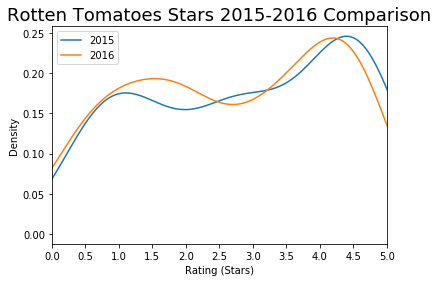

In [133]:
fig, ax = plt.subplots()
RT2015["RT_norm"].plot.kde(label="2015",legend=True,ax=ax)
RT2016["n_tmeter"].plot.kde(label="2016",legend=True,ax=ax)
ax.set_title("Rotten Tomatoes Stars 2015-2016 Comparison",fontsize=18)
ax.set_xlim([0,5])
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlabel("Rating (Stars)")
ax.set_ylabel("Density")

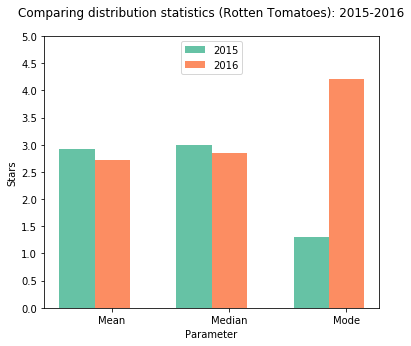

In [134]:
width = .3
fig, ax = plt.subplots(figsize=(6,5))
f1 = ax.bar(np.arange(3),stats["2015"],width,color=plt.cm.Set2(0))
f2 = ax.bar(np.arange(3)+width,stats["2016"],width,color=plt.cm.Set2(.20))
#stats["2015"].plot.bar(color="b",label="2015",legend=True)
#stats["2016"].plot.bar(color="r",label="2016",legend=True)
ax.set_title("Comparing distribution statistics (Rotten Tomatoes): 2015-2016", y = 1.05)
ax.set_xlabel("Parameter")
ax.set_ylabel("Stars")
ax.set_ylim([0.0,5.0])
ax.set_xticks([.3,1.3,2.3])
ax.set_yticks(np.arange(0,5.5,.5))
ax.set_xticklabels(stats.index)
ax.legend((f1[0], f2[0]), ('2015', '2016'), loc="upper center")
ax.autoscale_view()

Once again the distributions aren't as markedly different, but for Metacritic too there was a decrease in the mean of the distributions between 2015 and 2016. Once again, let's test the significance of this difference using the two-tailed approximate permutation test.

In [135]:
abs_mean_diff = abs(stats.at["Mean","2016"]-stats.at["Mean","2015"])
print("Difference of means (absolute): ", abs_mean_diff)

Difference of means (absolute):  0.20144283453062473


In [136]:
# Now we sample randomly from both sets and create new distributions with new differences in mean and mode. 
all_scores = RT2015["RT_norm"].append(RT2016["n_tmeter"])
abs_mean_diffs = []
for i in range(1000):
    dist_a = []
    dist_b = []
    for i in all_scores:
        if np.random.rand() >= .5:
            dist_a.append(i)
        else:
            dist_b.append(i)
    iter_mean_diff = abs(np.mean(dist_b)-np.mean(dist_a))
    abs_mean_diffs.append(iter_mean_diff)

In [137]:
# How often are these differences greater than the ones we obtained with the real distributions?
frequency = 0
for i in abs_mean_diffs:
    if i >= abs_mean_diff:
        frequency += 1
p_value_mean = frequency/len(abs_mean_diffs)
frequency = 0
for i in abs_mode_diffs:
    if i >= abs_mode_diff:
        frequency += 1
p_value_mode = frequency/len(abs_mode_diffs)
print("P-value (mean, two-tailed): ", p_value_mean)

P-value (mean, two-tailed):  0.247


The p-value for Rotten Tomatoes is way larger than the 5% confidence threshold! There's almost a 1-in-4 chance that the difference in Rotten Tomatoes score distributions between 2015 and 2016 was due to random chance.

# Conclusions

The difference in Fandango review score distributions between 2015 and 2016 is marked, both visually and statistically. A two-tailed approximate permutation test showed that there is less than a 1% chance that the difference in mean between the two distributions is due to random chance. Both a change in the scoring system and a genuine shift in movie quality between the two years could, however, explain the difference.

To settle the question, the same statistical test was performed on IMDB, Metacritic and Rotten Tomatoes scores. In all cases the mean decreased between 2015 and 2016, indicating that perhaps there really was some decrease in general quality of the movies. However, of the three only IMDB had a permutation test p-score below the confidence threshold, and even then with a value an order of magnitude larger than that for Fandango scores. Differences in Metacritic and Rotten Tomatoes score distributions were found to respectively have a ~1-in-10 and a ~1-in-4 chance of being due to random chance.

##### To conclude, it is likely that Fandango did in fact change its scoring system.